In [1]:
%%bash
git clone https://github.com/xiaohuiduan/dcgan_anime_avatars
mv /kaggle/working/dcgan_anime_avatars/data /kaggle/working/
rm -fr /kaggle/working/model_*.h5
ls /kaggle/working/data/ | wc -l

21551


Cloning into 'dcgan_anime_avatars'...
Updating files: 100% (21556/21556), done.


In [2]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.6.0
2.6.2


In [3]:
# 数据集的位置
avatar_img_path = "/kaggle/working/data"

import os

import cv2
import numpy as np
def load_data():
    """
    加载数据集
    :return: 返回numpy数组
    """
    all_images = []
    # 从本地文件读取图片加载到images_data中。
    for image_name in os.listdir(avatar_img_path):
        try:
            image = cv2.cvtColor(
                cv2.resize(
                    cv2.imread(os.path.join(avatar_img_path,image_name), cv2.IMREAD_COLOR),
                    (64, 64)
                    ),cv2.COLOR_BGR2RGB
                )
            all_images.append(image)
        except:
            continue
        
    all_images = np.array(all_images)
    # 将图片数值变成[-1,1]
    all_images = (all_images - 127.5) / 127.5
    # 将数据随机排序
    np.random.shuffle(all_images)
    return all_images[:10000]#只取前5000张以节省训练时间

img_dataset=load_data()
img_dataset.shape

(10000, 64, 64, 3)

In [4]:

import matplotlib.pyplot as plt
def show_images(images,index = -1):
    """
    展示并保存图片
    :param images: 需要show的图片
    :param index: 图片名
    :return:
    """
    plt.figure()
    for i, image in enumerate(images):
        ax = plt.subplot(5, 5, i+1)
        plt.axis('off')
        img=image-image.min(); img=img/img.max() #[-1,+1]转到[0,1]
        # print(img.max(),img.min(),img.mean())
        plt.imshow(img)
    plt.savefig("data_%d.png"%index)
    plt.show()

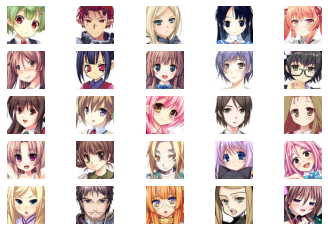

In [5]:
show_images(img_dataset[0: 25])

In [6]:
# noise的维度
noise_dim = 100
# 图片的shape
image_shape = (64,64,3)

In [7]:
from keras.models import Sequential,Model
from keras.layers import Dropout, Conv2D, Dense,  LeakyReLU, Input,Reshape,  Flatten,  Conv2DTranspose
#修改点: tensorflow.
from tensorflow.keras.optimizers import Adam,RMSprop

In [8]:
def build_G():
    """
    构建生成器
    :return:
    """
    model = Sequential()
    model.add(Input(shape=noise_dim))

    model.add(Dense(128*32*32))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((32,32,128)))
    
    model.add(Conv2D(256,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2DTranspose(256,4,strides=2,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(256,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    
    model.add(Conv2D(256,5,padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(3,7,activation='tanh',padding='same'))
    
    return model

G = build_G()

2022-02-18 10:07:21.428524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 10:07:21.559227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 10:07:21.559930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-18 10:07:21.561016: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [9]:
opt_d=Adam(learning_rate=0.0002, beta_1=0.5)
opt_gan=Adam(learning_rate=0.0002, beta_1=0.5)

# opt_d=RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
# opt_gan=RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
#RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
#Adam(learning_rate=0.0002, beta_1=0.5)
    
def build_D():
    """
    构建判别器
    :return: 
    """
    model = Sequential()
    
    # 卷积层
    model.add(Conv2D(128,3,input_shape = image_shape))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4, strides=2))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4, strides=2))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128,4, strides=2))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.4))

    model.add(Dense(1,activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer=opt_d) 
    return model
D = build_D()

In [10]:

def build_gan():
    """
    构建GAN网络
    :return:
    """
    # 冷冻判别器，也就是在训练的时候只优化G的网络权重，而对D保持不变
    D.trainable = False
    # GAN网络的输入
    gan_input = Input(shape=(noise_dim,))
    # GAN网络的输出
    gan_out = D(G(gan_input))
    # 构建网络
    gan = Model(gan_input,gan_out)
    # 编译GAN网络，使用Adam优化器，以及加上交叉熵损失函数（一般用于二分类）
    gan.compile(loss='binary_crossentropy',optimizer=opt_gan)
    return gan
GAN = build_gan()

In [11]:

def sample_noise(batch_size):
    """
    随机产生正态分布（0，1）的noise
    :param batch_size:
    :return: 返回的shape为(batch_size,noise)
    """
    return np.random.normal(size=(batch_size, noise_dim))

def smooth_pos_labels(y):
    """
    使得true label的值的范围为[0.8,1]
    :param y:
    :return:
    """
    return y - (np.random.random(y.shape) * 0.2)

def smooth_neg_labels(y):
    """
    使得fake label的值的范围为[0.0,0.3]
    :param y:
    :return:
    """
    return y + np.random.random(y.shape) * 0.3

In [12]:

def load_batch(data, batch_size,index):
    """
    按批次加载图片
    :param data: 图片数据集
    :param batch_size: 批次大小
    :param index: 批次序号
    :return:
    """
    return data[index*batch_size: (index+1)*batch_size]

In [13]:
import datetime
def train(epochs=100, batch_size=64):
    """
    训练函数
    :param epochs: 训练的次数
    :param batch_size: 批尺寸
    :return:
    """
    # 判别器损失
    discriminator_loss = 0
    # 生成器损失
    generator_loss = 0
    
    # img_dataset.shape[0] / batch_size 代表这个数据可以分为几个批次进行训练
    n_batches = int(img_dataset.shape[0] / batch_size)
    
    for i in range(epochs):
        pre_now=datetime.datetime.now()
        for batch_index in range(n_batches):
            # 按批次加载数据
            x = load_batch(img_dataset, batch_size,batch_index )
            # 产生noise
            noise = sample_noise(batch_size)
            # G网络产生图片
            generated_images = G.predict(noise)
            # 产生为1的标签
            y_real = np.ones(batch_size)
            # 将1标签的范围变成[0.8 , 1.0]
            y_real = smooth_pos_labels(y_real)
            # 产生为0的标签
            y_fake = np.zeros(batch_size)
            # 将0标签的范围变成[0.0 , 0.3]
            y_fake = smooth_neg_labels(y_fake)
            # 训练真图片loss
            d_loss_real = D.train_on_batch(x, y_real)
            # 训练假图片loss
            d_loss_fake = D.train_on_batch(generated_images, y_fake)

            discriminator_loss = d_loss_real + d_loss_fake
            # 产生为1的标签
            y_real_g = np.ones(batch_size)
            # 训练GAN网络，input = fake_img ,label = 1
            generator_loss = GAN.train_on_batch(noise, y_real_g)
        
        now=datetime.datetime.now()
        print(f'[Epoch {i}]. Discriminator loss : {discriminator_loss}. Generator_loss: {generator_loss}, time spent: {now-pre_now}')

        # 每个epoch保存一次。
        if i%1 == 0:
            # 随机产生(25,100)的noise
            test_noise = sample_noise(25)
            # 使用G网络生成25张图偏
            test_images = G.predict(test_noise)
            # show 预测 img
            show_images(test_images,i)
            GAN.save_weights(f'model_{i}.h5')

2022-02-18 10:07:24.114004: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-18 10:07:25.686027: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[Epoch 0]. Discriminator loss : 1.206822156906128. Generator_loss: 0.6890831589698792, time spent: 0:02:06.759813


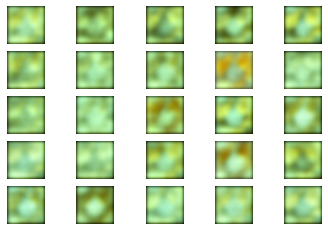

[Epoch 1]. Discriminator loss : 0.9925138354301453. Generator_loss: 2.298837661743164, time spent: 0:01:42.918843


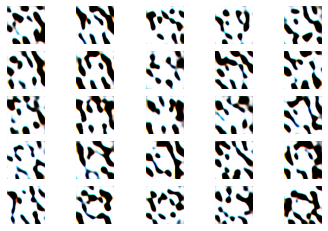

[Epoch 2]. Discriminator loss : 0.8414756059646606. Generator_loss: 2.4746549129486084, time spent: 0:01:43.115579


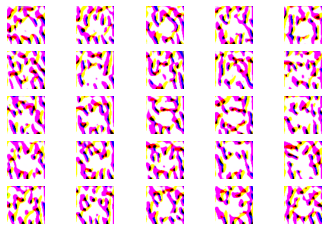

[Epoch 3]. Discriminator loss : 1.1913294196128845. Generator_loss: 1.660233974456787, time spent: 0:01:41.656114


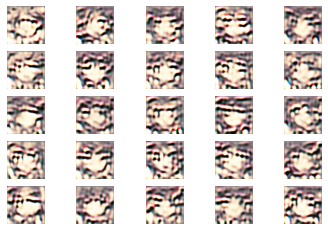

[Epoch 4]. Discriminator loss : 1.0395870506763458. Generator_loss: 1.9009387493133545, time spent: 0:01:44.415836


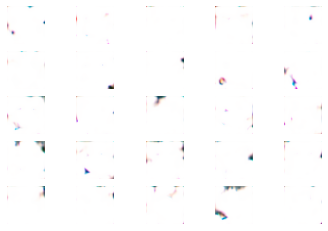

[Epoch 5]. Discriminator loss : 1.140872597694397. Generator_loss: 1.1866947412490845, time spent: 0:01:43.578626


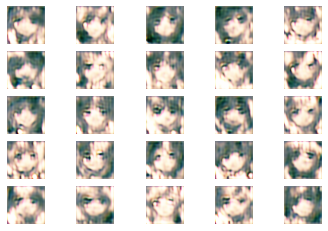

[Epoch 6]. Discriminator loss : 1.2416766285896301. Generator_loss: 1.647836685180664, time spent: 0:01:42.952052


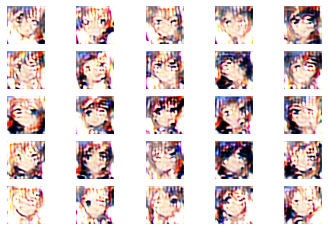

[Epoch 7]. Discriminator loss : 1.1517184376716614. Generator_loss: 1.665140151977539, time spent: 0:01:44.613879


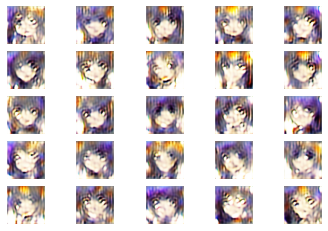

[Epoch 8]. Discriminator loss : 1.155699074268341. Generator_loss: 1.7392630577087402, time spent: 0:01:42.113981


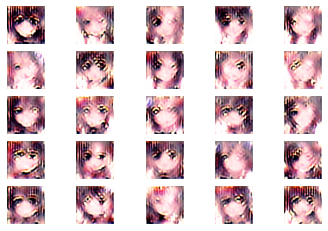

[Epoch 9]. Discriminator loss : 1.2003583312034607. Generator_loss: 1.1000490188598633, time spent: 0:01:44.032987


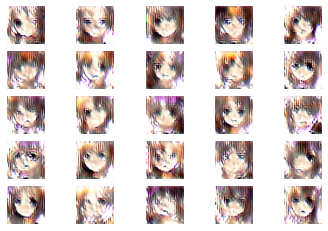

[Epoch 10]. Discriminator loss : 1.2785635590553284. Generator_loss: 1.299595832824707, time spent: 0:01:43.202551


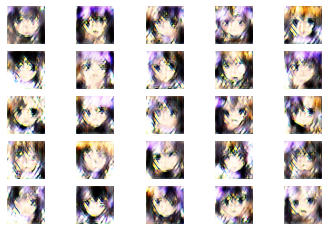

[Epoch 11]. Discriminator loss : 1.3733437061309814. Generator_loss: 0.7901795506477356, time spent: 0:01:42.621968


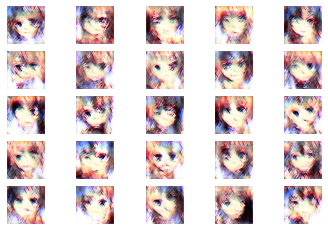

[Epoch 12]. Discriminator loss : 1.3301544785499573. Generator_loss: 0.8681764602661133, time spent: 0:01:41.273531


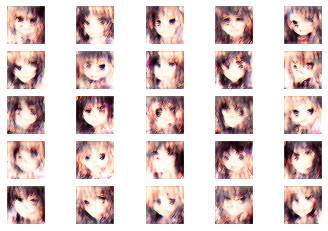

[Epoch 13]. Discriminator loss : 1.3409085273742676. Generator_loss: 0.7963901162147522, time spent: 0:01:42.327066


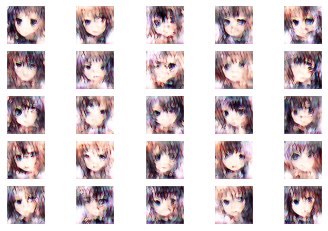

[Epoch 14]. Discriminator loss : 1.3762565851211548. Generator_loss: 0.7923805713653564, time spent: 0:01:42.626159


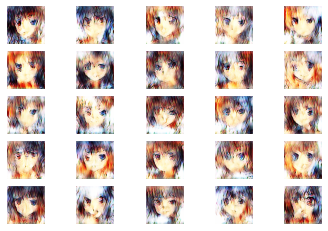

[Epoch 15]. Discriminator loss : 1.3737489581108093. Generator_loss: 0.9125746488571167, time spent: 0:01:42.576603


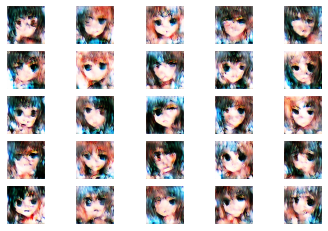

[Epoch 16]. Discriminator loss : 1.3722752928733826. Generator_loss: 0.7471141219139099, time spent: 0:01:42.679872


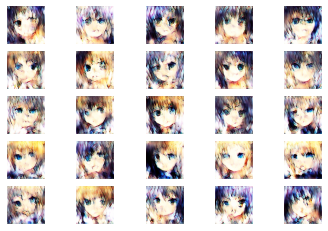

[Epoch 17]. Discriminator loss : 1.3662987351417542. Generator_loss: 0.7176626920700073, time spent: 0:01:43.029585


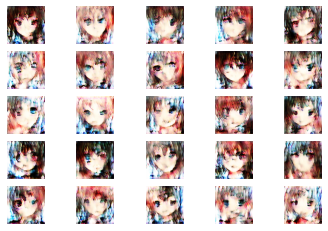

[Epoch 18]. Discriminator loss : 1.378771424293518. Generator_loss: 0.69256192445755, time spent: 0:01:41.404568


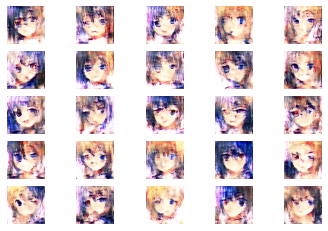

[Epoch 19]. Discriminator loss : 1.420307695865631. Generator_loss: 0.6999706625938416, time spent: 0:01:42.874603


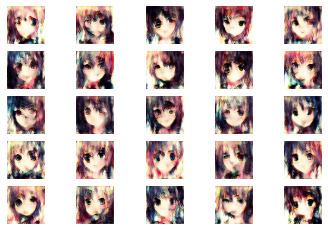

In [14]:
train(epochs=20, batch_size=256)